# ImageNet classification from pretrained models

In this notebook we benchmark various trained models on the ImageNet classification task. The following models (with their weights) are downloaded directly from torchvision:
- AlexNet
- VGG16
- Inception v3
- ResNet18
- ResNet101 

In particular we compare accuracy, top-5 accuracy, and inference speed.

In [1]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

from torchinfo import summary

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json, os, glob, time

import utils
import utils.data, utils.ML, utils.models
from utils.models import number_of_parameters

# Load sample data

In [3]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
)])

torch.Size([3, 800, 800])


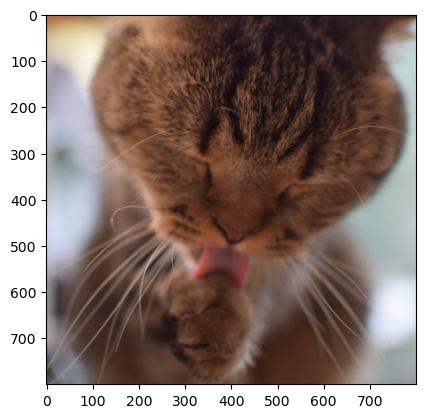

In [4]:
im_PIL = Image.open("/Users/lucas/Documents/Data/sample_images/cat.jpg")
# im_PIL = Image.open("/Users/lucas/Documents/Data/sample_images/spider.jpg")

im = transforms.ToTensor()(im_PIL)

print(im.shape)

plt.imshow(np.transpose(im, (1, 2, 0)))

In [5]:
im_pp = preprocess(im_PIL).unsqueeze(0)

print(im_pp.shape)

torch.Size([1, 3, 224, 224])


In [6]:
# im_resize = transforms.Resize(256)(im)
# im_crop = transforms.CenterCrop(224)(im_resize)

# plt.figure()
# plt.imshow(np.transpose(im, (1, 2, 0)))

# plt.figure()
# plt.imshow(np.transpose(im_resize, (1, 2, 0)))

# plt.figure()
# plt.imshow(np.transpose(im_crop, (1, 2, 0)))

### Load labels:

In [7]:
with open('/Users/lucas/Documents/data/ImageNet/imagenet_labels.txt', 'r') as f:
    txt = f.read()
    classes = txt.splitlines()

# Alexnet

In [33]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet.eval()

alexnet_preprocessing = models.AlexNet_Weights.IMAGENET1K_V1.transforms()

In [9]:
def top5pred(model, image):
    ''' Return top 5 predictions, and their confidences '''
    
    model.eval()
    with torch.no_grad():
        out = model(image)

    softmax = F.softmax(out, dim=1)[0].detach().numpy()

    asort = np.argsort(softmax)[::-1]
    
    idxs = asort[:5]
    confs = softmax[idxs]
    return list(zip(idxs, confs))

In [10]:
im_pproc = alexnet_preprocessing(im_PIL).unsqueeze(0)

predictions = top5pred(alexnet, im_pproc)

In [11]:
for pred in predictions:
    print(f'{classes[pred[0]]:<35} | confidence: {pred[1]*100:.2f}%')

tabby, tabby cat                    | confidence: 55.71%
tiger cat                           | confidence: 26.35%
Egyptian cat                        | confidence: 14.07%
hare                                | confidence: 0.44%
crossword puzzle, crossword         | confidence: 0.40%


# VGG

In [12]:
VGG16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

VGG_preprocessing = models.VGG16_Weights.IMAGENET1K_V1.transforms()

In [13]:
im_pproc = VGG_preprocessing(im_PIL).unsqueeze(0)

predictions = top5pred(VGG16, im_pproc)

In [14]:
for pred in predictions:
    print(f'{classes[pred[0]]:<35} | confidence: {pred[1]*100:.2f}%')

tabby, tabby cat                    | confidence: 55.97%
Egyptian cat                        | confidence: 25.20%
tiger cat                           | confidence: 16.51%
lynx, catamount                     | confidence: 0.89%
mouse, computer mouse               | confidence: 0.17%


# Inception v3

In [15]:
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

inception_preprocessing = models.Inception_V3_Weights.IMAGENET1K_V1.transforms()

In [16]:
im_pproc = inception_preprocessing(im_PIL).unsqueeze(0)

predictions = top5pred(inception, im_pproc)

In [17]:
for pred in predictions:
    print(f'{classes[pred[0]]:<65} | confidence: {pred[1]*100:.2f}%')

tabby, tabby cat                                                  | confidence: 66.97%
tiger cat                                                         | confidence: 23.28%
Egyptian cat                                                      | confidence: 1.98%
Persian cat                                                       | confidence: 0.84%
plastic bag                                                       | confidence: 0.30%


# ResNet18

In [18]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet_preprocessing = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

In [19]:
im_pproc = resnet_preprocessing(im_PIL).unsqueeze(0)

predictions = top5pred(resnet18, im_pproc)

In [20]:
for pred in predictions:
    print(f'{classes[pred[0]]:<65} | confidence: {pred[1]*100:.2f}%')

tabby, tabby cat                                                  | confidence: 65.42%
tiger cat                                                         | confidence: 25.73%
Egyptian cat                                                      | confidence: 6.76%
Persian cat                                                       | confidence: 1.36%
lynx, catamount                                                   | confidence: 0.19%


# ResNet101

In [21]:
resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

resnet_preprocessing = models.ResNet101_Weights.IMAGENET1K_V1.transforms()

In [22]:
im_pproc = resnet_preprocessing(im_PIL).unsqueeze(0)

predictions = top5pred(resnet18, im_pproc)

In [23]:
for pred in predictions:
    print(f'{classes[pred[0]]:<65} | confidence: {pred[1]*100:.2f}%')

tabby, tabby cat                                                  | confidence: 65.42%
tiger cat                                                         | confidence: 25.73%
Egyptian cat                                                      | confidence: 6.76%
Persian cat                                                       | confidence: 1.36%
lynx, catamount                                                   | confidence: 0.19%


# Evaluate on ImageNet validation set

In [34]:
path_to_im_folder = "/Users/lucas/Documents/Data/ImageNet/ILSVRC2012_img_val/"
path_to_labels_txt = "/Users/lucas/Documents/Data/ImageNet/imagenet_2012_validation_label_idxs.txt"

imagenet_val = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, alexnet_preprocessing)

batch_size = 16
val_dataloader = torch.utils.data.DataLoader(imagenet_val, batch_size=batch_size)

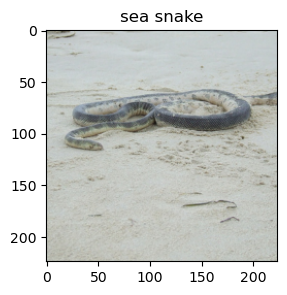

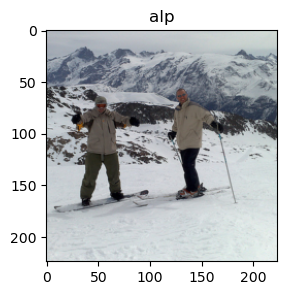

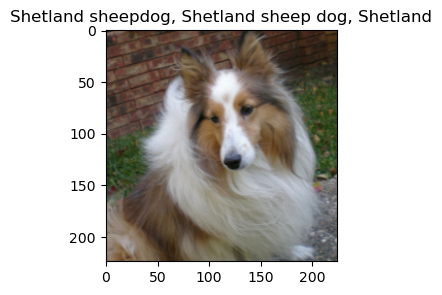

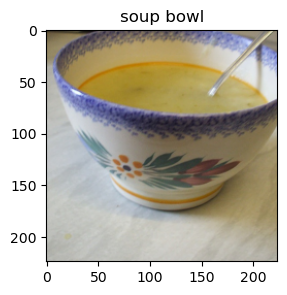

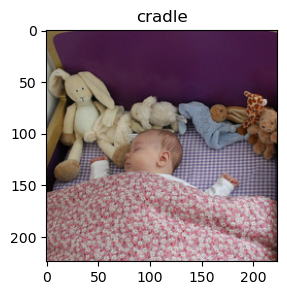

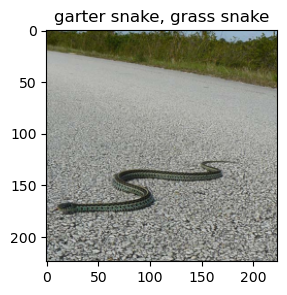

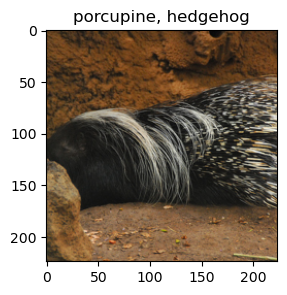

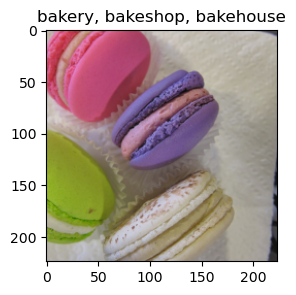

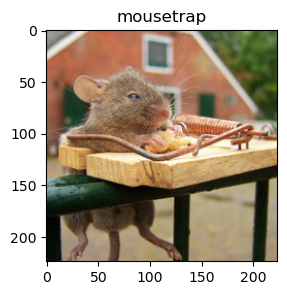

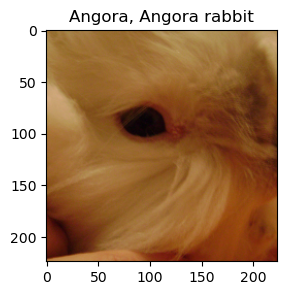

In [29]:
# Plot a few images:

denorm = transforms.Compose([transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
                           transforms.Normalize([-0.485, -0.456, -0.406], [1., 1., 1.])])

for i in range(10):
    
    im, y = imagenet_val[i]   
    im_denorm = denorm(im)
    
    plt.figure(figsize=(3, 3))
    plt.imshow(np.transpose(im_denorm, (1, 2, 0)))
    plt.title(classes[y])

In [37]:
device = "mps"
loss_fn = nn.CrossEntropyLoss()

batch_size = 32
num_workers = 4

In [38]:
print("=== AlexNet: ===")

imagenet_val = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, transform=alexnet_preprocessing)
dataloader = torch.utils.data.DataLoader(imagenet_val, batch_size=batch_size, num_workers=num_workers)

t = time.time()
loss, accuracy, top5_accuracy = utils.ML.evaluate_ImageNet(alexnet.to(device), dataloader, loss_fn, device)
dt = time.time()-t
print(f"Loss: {loss:.3f}, accuracy: {accuracy:.3f}, top-5 accuracy: {top5_accuracy:.3f}")
print(f"Inference time: {dt/60:.2f} min")


=== AlexNet: ===
Loss: 1.910, accuracy: 0.565, top-5 accuracy: 0.791
Inference time: 1.58 min


In [39]:
print("=== VGG16: ===")

imagenet_val = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, transform=VGG_preprocessing)
dataloader = torch.utils.data.DataLoader(imagenet_val, batch_size=batch_size, num_workers=num_workers)

t = time.time()
loss, accuracy, top5_accuracy = utils.ML.evaluate_ImageNet(VGG16.to(device), dataloader, loss_fn, device)
dt = time.time()-t
print(f"Loss: {loss:.3f}, accuracy: {accuracy:.3f}, top-5 accuracy: {top5_accuracy:.3f}")
print(f"Inference time: {dt/60:.2f} min")

=== VGG16: ===
Loss: 1.145, accuracy: 0.716, top-5 accuracy: 0.904
Inference time: 7.86 min


In [40]:
print("=== Inception: ===")

imagenet_val = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, transform=inception_preprocessing)
dataloader = torch.utils.data.DataLoader(imagenet_val, batch_size=batch_size, num_workers=num_workers)

t = time.time()
loss, accuracy, top5_accuracy = utils.ML.evaluate_ImageNet(inception.to(device), dataloader, loss_fn, device)
dt = time.time()-t
print(f"Loss: {loss:.3f}, accuracy: {accuracy:.3f}, top-5 accuracy: {top5_accuracy:.3f}")
print(f"Inference time: {dt/60:.2f} min")

=== Inception: ===
Loss: 0.973, accuracy: 0.775, top-5 accuracy: 0.936
Inference time: 6.36 min


In [41]:
print("=== ResNet18: ===")

imagenet_val = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, transform=resnet_preprocessing)
dataloader = torch.utils.data.DataLoader(imagenet_val, batch_size=batch_size, num_workers=num_workers)

t = time.time()
loss, accuracy, top5_accuracy = utils.ML.evaluate_ImageNet(resnet18.to(device), dataloader, loss_fn, device)
dt = time.time()-t
print(f"Loss: {loss:.3f}, accuracy: {accuracy:.3f}, top-5 accuracy: {top5_accuracy:.3f}")
print(f"Inference time: {dt/60:.2f} min")

=== ResNet18: ===
Loss: 1.247, accuracy: 0.698, top-5 accuracy: 0.891
Inference time: 1.90 min


In [42]:
print("=== ResNet101: ===")

t = time.time()
loss, accuracy, top5_accuracy = utils.ML.evaluate_ImageNet(resnet101.to(device), dataloader, loss_fn, device)
dt = time.time()-t
print(f"Loss: {loss:.3f}, accuracy: {accuracy:.3f}, top-5 accuracy: {top5_accuracy:.3f}")
print(f"Inference time: {dt/60:.2f} min")

=== ResNet101: ===
Loss: 0.912, accuracy: 0.774, top-5 accuracy: 0.935
Inference time: 8.34 min
